In [1]:
from pathlib import Path
base_path = Path("/cta/share/users/ProteinGym/DMS_Assays(Substitutions)")
list(base_path.glob("*.csv"))[:5]

[PosixPath('/cta/share/users/ProteinGym/DMS_Assays(Substitutions)/VG08_BPP22_Tsuboyama_2023_2GP8.csv'),
 PosixPath('/cta/share/users/ProteinGym/DMS_Assays(Substitutions)/CAPSD_AAV2S_Sinai_2021.csv'),
 PosixPath('/cta/share/users/ProteinGym/DMS_Assays(Substitutions)/A0A192B1T2_9HIV1_Haddox_2018.csv'),
 PosixPath('/cta/share/users/ProteinGym/DMS_Assays(Substitutions)/ESTA_BACSU_Nutschel_2020.csv'),
 PosixPath('/cta/share/users/ProteinGym/DMS_Assays(Substitutions)/SAV1_MOUSE_Tsuboyama_2023_2YSB.csv')]

In [2]:
import pandas as pd
# df = pd.concat((pd.read_csv(file) for file in base_path.rglob("*.csv")), ignore_index=True)
files = list(base_path.rglob("*.csv"))
proteins = [pd.read_csv(file) for file in files]

In [3]:
files[1]

PosixPath('/cta/share/users/ProteinGym/DMS_Assays(Substitutions)/CAPSD_AAV2S_Sinai_2021.csv')

In [4]:
proteins[1].head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,A572C,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,0.783106,1
1,A572C:E574A,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-1.910004,0
2,A572C:E574A:Q584C:R585V,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-4.135085,0
3,A572C:E574A:S578V:Q584C:R585P,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-4.901771,0
4,A572C:E574A:T581S:N582G,MAADGYLPDWLEDTLSEGIRQWWKLKPGPPPPKPAERHKDDSRGLV...,-2.227975,0


In [5]:
import numpy as np

# Given a dataframe containing a DMS assay belongin to a single protein (from single .csv file)
# Calculate functional map of that sequence 
def extract_func_map(df):
    # Ignore multiple mutations for now (can only handle single mutation per entry)
    df = df[~df["mutant"].str.contains(":")].copy()
    idx = df["mutated_sequence"].first_valid_index()
    mut_seq = df["mutated_sequence"][idx]
    mu = np.mean(df["DMS_score"])
    stddev = np.std(df["DMS_score"])
    df["Z_scores"] = (df["DMS_score"] - mu)/stddev
    df["mut_positions"] = df["mutant"].apply(lambda x: int(x[1:-1]) - 1)
    func_map = df.groupby("mut_positions")["Z_scores"].mean()
    func_vals = np.zeros((len(mut_seq), ))
    func_vals.fill(np.nan)
    func_vals[func_map.index.to_numpy()] = func_map.to_numpy()
    return func_vals
    

In [6]:
proteins[1].head()
len(proteins)

217

In [18]:
sequences = []
func_maps = []

for i, prot in enumerate(proteins):
    print(f"Processing {i}th protein")
    # Ignore proteins that contain multi-position mutations
    # if prot["mutant"].str.contains(":").sum() > 0: 
    #     continue

    df = prot.copy()
    # Find the non-mutated sequence (can handle multi mutations)
    idx = df["mutant"].first_valid_index()
    mutations = df["mutant"][idx]
    mut_seq = df["mutated_sequence"][idx]
    ori_seq = mut_seq
    for mut in mutations.split(":"):
        mut_pos = int(mut[1:-1])
        ori_seq = ori_seq[:mut_pos-1] + mut[0] + ori_seq[mut_pos:]

    # Duplicate multi-mutation lines into lines of single mutations, 
    # scores are distributed equally
    df['mutations'] = df['mutant'].str.split(':')
    df['num_mutations'] = df['mutations'].apply(len)
    df = df.explode('mutations', ignore_index=True)
    df['DMS_score'] = df['DMS_score'] / df['num_mutations'] # This is the score sharing
    df = df.drop(columns=['mutant', 'num_mutations'])
    df = df.rename(columns={'mutations': 'mutant'})
    
    func = extract_func_map(df)
    sequences.append(ori_seq)
    func_maps.append(func)

Processing 0th protein
Processing 1th protein
Processing 2th protein
Processing 3th protein
Processing 4th protein
Processing 5th protein
Processing 6th protein
Processing 7th protein
Processing 8th protein
Processing 9th protein
Processing 10th protein
Processing 11th protein
Processing 12th protein
Processing 13th protein
Processing 14th protein
Processing 15th protein
Processing 16th protein
Processing 17th protein
Processing 18th protein
Processing 19th protein
Processing 20th protein
Processing 21th protein
Processing 22th protein
Processing 23th protein
Processing 24th protein
Processing 25th protein
Processing 26th protein
Processing 27th protein
Processing 28th protein
Processing 29th protein
Processing 30th protein
Processing 31th protein
Processing 32th protein
Processing 33th protein
Processing 34th protein
Processing 35th protein
Processing 36th protein
Processing 37th protein
Processing 38th protein
Processing 39th protein
Processing 40th protein
Processing 41th protein
Pr

In [19]:
from tokenizers import Tokenizer

In [20]:
tkz_path = "/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref50_bpe_51200.json"
tkz1 = Tokenizer.from_file(tkz_path)
tkz_path = "/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref50_mutbpe_0.7_3_12_0.05_51200.json"
tkz2 = Tokenizer.from_file(tkz_path)

In [21]:
tkz1_vals = []
tkz2_vals = []
for i, seq in enumerate(sequences):
    offs1 = tkz1.encode(seq).offsets
    offs2 = tkz2.encode(seq).offsets
    func_map = np.abs(func_maps[i])
    # func_map = func_maps[i]
    for s, e in offs1:
        tkz1_vals.append(np.mean(func_map[s:e]))
    for s, e in offs2:
        tkz2_vals.append(np.mean(func_map[s:e]))


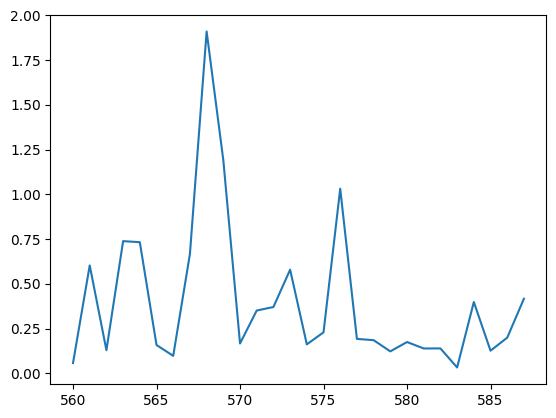

In [22]:
# plt.plot(np.abs(func_maps[1]) > 0)
plt.plot(np.abs(func_maps[1]))


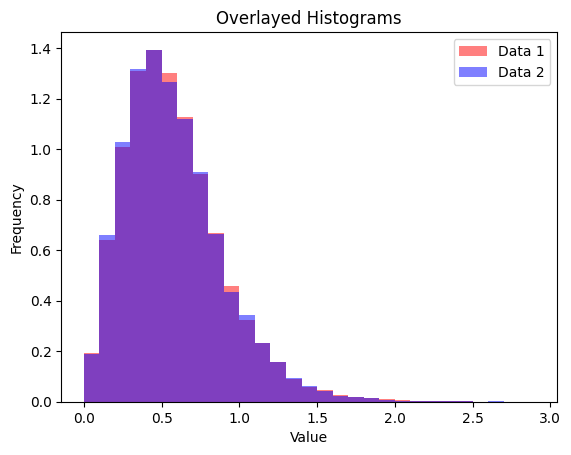

In [24]:
import matplotlib.pyplot as plt
plt.hist(tkz1_vals, bins=np.arange(0, 3, 0.1), alpha=0.5, color='red', label='Data 1', density=True)
plt.hist(tkz2_vals, bins=np.arange(0, 3, 0.1), alpha=0.5, color='blue', label='Data 2',  density=True)

# Add legend and labels
plt.legend()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Overlayed Histograms')

plt.show()

In [ ]:
np.mean(tkz2_vals)

np.float64(nan)

- Disagreement olan tokenlari incele, agreement olan tokenlardan geriye kalan bolgelere bak

In [ ]:
set(offs2) - set(offs1)


{(1, 3),
 (3, 6),
 (13, 14),
 (14, 17),
 (17, 19),
 (19, 22),
 (22, 25),
 (32, 36),
 (36, 39),
 (45, 47),
 (47, 51),
 (51, 55)}

In [ ]:
tkz1_vals = []
tkz2_vals = []
for i, seq in enumerate(sequences):
    offs1 = tkz1.encode(seq).offsets
    offs2 = tkz2.encode(seq).offsets
    func_map = np.abs(func_maps[i])
    # func_map = func_maps[i]
    for s, e in (set(offs1) - set(offs2)):
        tkz1_vals.append(np.mean(func_map[s:e]))
    for s, e in (set(offs2) - set(offs1)):
        tkz2_vals.append(np.mean(func_map[s:e]))

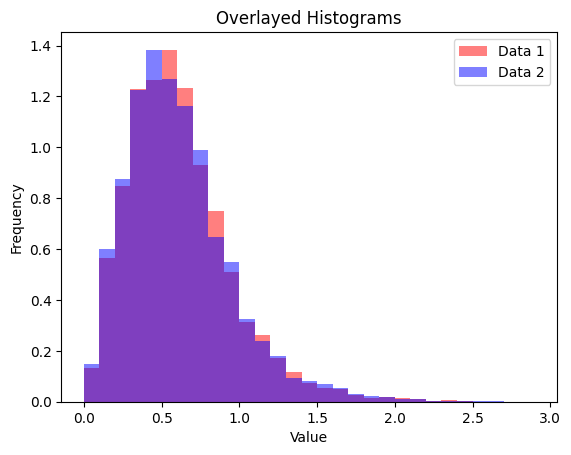

In [ ]:
import matplotlib.pyplot as plt
plt.hist(tkz1_vals, bins=np.arange(0, 3, 0.1), alpha=0.5, color='red', label='Data 1', density=True)
plt.hist(tkz2_vals, bins=np.arange(0, 3, 0.1), alpha=0.5, color='blue', label='Data 2',  density=True)

# Add legend and labels
plt.legend()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Overlayed Histograms')

plt.show()

In [ ]:
len(tkz2_vals[~np.isnan(tkz2_vals)])

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
tkz2_vals

[np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(0.6322473254514928),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(0.5595844882202181),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan)